In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import folium
import json

# misc
import country_converter as coco
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
from datetime import datetime
from datetime import timedelta
from mizani.breaks import date_breaks, minor_breaks
from mizani.formatters import date_format

### Import BRFSS data set (features selected for diabetes study)

In [185]:
# read in BRFSS data
dat = pd.read_csv("../project/Data/brfss.csv", encoding = "ISO-8859-1")
# drop unuseful columns + rename gender to "male" (male==1, female==2)
dat = dat.drop(['Unnamed: 0',"age_diagnose"], axis=1).rename(columns={"gender": "male",
                                                                      "alcohol":"heavy_drinker"}).reset_index(drop=True)

# drop rows with missing data: age, healthcare info, checkup and any other column
dat = dat.drop(dat[dat.age == 14].index).dropna().reset_index(drop=True)
# convert data types in the dataset to int
dat = dat.astype(int)

# recode female == 0, heavy drinker == 1, no healthcare == 0
dat.loc[dat['male'] == 2, ['male']] = 0
dat.loc[dat['healthcare_coverage'] == 2, ['healthcare_coverage']] = 0
dat.loc[dat['heavy_drinker'] == 1, ['heavy_drinker']] = 0
dat.loc[dat['heavy_drinker'] == 2, ['heavy_drinker']] = 1

# check dimension and rows
print(dat.shape)
# check out all of the columns names and data types in the dataset
print(dat.dtypes)

(127193, 21)
type2diabetes          int64
male                   int64
age                    int64
healthcare_coverage    int64
checkup                int64
mental_health          int64
bmi                    int64
heart_disease          int64
kidney_disease         int64
depression             int64
concentrate_decide     int64
blind                  int64
heavy_drinker          int64
smoke                  int64
exercise               int64
income                 int64
race                   int64
employed               int64
marital                int64
edu                    int64
city_rural             int64
dtype: object


In [186]:
# drop obs where respondent refuse to answer or don't know
dat = dat.drop(dat[dat.edu==9 | (dat.marital==9)].index)
dat = dat.drop(dat[(dat.employed==9) | (dat.race==9)].index)
dat = dat.drop(dat[(dat.income==99)| (dat.race==9)].index)
dat = dat.drop(dat[(dat.exercise==9)| (dat.smoke==9)].index)
dat = dat.drop(dat[(dat.heavy_drinker==9)| (dat.blind==9)].index)
dat = dat.drop(dat[(dat.concentrate_decide==9)| (dat.depression==9)].index)
dat = dat.drop(dat[(dat.kidney_disease==9)| (dat.heart_disease==9)].index)
dat = dat.drop(dat[(dat.mental_health==99)| (dat.mental_health==77)].index)
dat = dat.drop(dat[(dat.checkup==7)| (dat.checkup==9)].index)
dat = dat.drop(dat[(dat.exercise==7)|(dat.income==77)].index)
dat_clean = dat.drop(dat[(dat.healthcare_coverage==9)|(dat.healthcare_coverage==7)].index).reset_index(drop=True)

dat_clean 

,type2diabetes,male,age,healthcare_coverage,checkup,mental_health,bmi,heart_disease,kidney_disease,depression,...,blind,heavy_drinker,smoke,exercise,income,race,employed,marital,edu,city_rural
0,0,0,11,1,1,88,2,2,2,2,...,1,0,4,1,5,1,7,1,3,2
1,1,0,10,1,1,30,4,2,2,2,...,2,0,4,1,7,2,7,3,4,3
2,1,1,11,1,1,88,4,2,2,2,...,2,0,1,1,7,1,7,2,4,5
3,0,0,11,1,1,4,2,2,2,2,...,2,0,1,1,7,1,7,2,4,1
4,0,1,12,1,1,88,3,2,2,2,...,2,0,3,1,8,1,7,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92746,1,1,11,1,1,88,4,2,2,2,...,1,0,3,2,3,1,7,3,3,5
92747,0,0,12,1,1,88,4,2,2,2,...,2,0,3,1,3,1,8,3,3,5
92748,0,0,12,1,1,88,4,2,2,2,...,2,0,3,1,5,1,7,2,3,1
92749,0,1,13,1,1,88,3,2,2,2,...,2,0,4,1,5,1,7,1,2,5


In [217]:
dat_clean.describe()

,type2diabetes,male,age,healthcare_coverage,mental_health,heart_disease,kidney_disease,depression,concentrate_decide,blind,heavy_drinker,exercise,race,employed,marital,edu,city_rural
count,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.00000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000
mean,0.173497,0.404901,9.838072,0.967763,2.958825,1.96979,1.964033,1.843743,1.934502,1.956313,0.053509,0.729502,1.413268,4.828681,2.040722,3.159847,2.941413
std,0.378678,0.490876,2.443754,0.176629,7.197894,0.57314,0.356624,0.451990,0.414522,0.311071,0.225047,0.444220,1.375018,2.794175,1.395036,0.849151,1.660837
min,0.000000,0.000000,3.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,0.000000,0.000000,8.000000,1.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,0.000000,0.000000,10.000000,1.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,7.000000,1.000000,3.000000,3.000000
75%,0.000000,1.000000,12.000000,1.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,7.000000,3.000000,4.000000,5.000000
max,1.000000,1.000000,13.000000,1.000000,30.000000,7.00000,7.000000,7.000000,7.000000,7.000000,1.000000,1.000000,8.000000,8.000000,9.000000,9.000000,5.000000


In [188]:
# recode some variables:
dat_clean.loc[dat_clean['checkup'] == 1, ['checkup']] = "Within_past_yr"
dat_clean.loc[dat_clean['checkup'] == 2, ['checkup']] = "Within_past_2_yrs"
dat_clean.loc[dat_clean['checkup'] == 3, ['checkup']] = "Within_past_5_yrs"
dat_clean.loc[dat_clean['checkup'] == 4, ['checkup']] = "5_or_more_yrs"
dat_clean.loc[dat_clean['checkup'] == 8, ['checkup']] = "Never"

dat_clean.loc[dat_clean['bmi']==1,['bmi']] = "Underweight"
dat_clean.loc[dat_clean['bmi']==2,['bmi']] = "Normal_weight"
dat_clean.loc[dat_clean['bmi']==3,['bmi']] = "Overweight"
dat_clean.loc[dat_clean['bmi']==4,['bmi']] = "Obese"

dat_clean.loc[dat_clean['smoke']==1,['smoke']] = "Everyday_smoker"
dat_clean.loc[dat_clean['smoke']==2,['smoke']] = "Someday_smoker"
dat_clean.loc[dat_clean['smoke']==3,['smoke']] = "Former_smoker"
dat_clean.loc[dat_clean['smoke']==4,['smoke']] = "Nonsmoker"

dat_clean.loc[dat_clean['mental_health']==88,['mental_health']] = 0

dat_clean.loc[dat_clean['exercise']==2,['exercise']] = 0

dat_clean.loc[dat_clean['income']==1,['income']] = "Less_than_$10K"
dat_clean.loc[dat_clean['income']==2,['income']] = "$10K_15K"
dat_clean.loc[dat_clean['income']==3,['income']] = "$15K_20K"
dat_clean.loc[dat_clean['income']==4,['income']] = "$20K_25K"
dat_clean.loc[dat_clean['income']==5,['income']] = "$25K_35K"
dat_clean.loc[dat_clean['income']==6,['income']] = "$35K_50K"
dat_clean.loc[dat_clean['income']==7,['income']] = "$50K_75K"
dat_clean.loc[dat_clean['income']==8,['income']] = "$75K_or_more"


In [216]:
dat_clean.describe()

,type2diabetes,male,age,healthcare_coverage,mental_health,heart_disease,kidney_disease,depression,concentrate_decide,blind,heavy_drinker,exercise,race,employed,marital,edu,city_rural
count,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.00000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000,92751.000000
mean,0.173497,0.404901,9.838072,0.967763,2.958825,1.96979,1.964033,1.843743,1.934502,1.956313,0.053509,0.729502,1.413268,4.828681,2.040722,3.159847,2.941413
std,0.378678,0.490876,2.443754,0.176629,7.197894,0.57314,0.356624,0.451990,0.414522,0.311071,0.225047,0.444220,1.375018,2.794175,1.395036,0.849151,1.660837
min,0.000000,0.000000,3.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,0.000000,0.000000,8.000000,1.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,0.000000,0.000000,10.000000,1.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,7.000000,1.000000,3.000000,3.000000
75%,0.000000,1.000000,12.000000,1.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,7.000000,3.000000,4.000000,5.000000
max,1.000000,1.000000,13.000000,1.000000,30.000000,7.00000,7.000000,7.000000,7.000000,7.000000,1.000000,1.000000,8.000000,8.000000,9.000000,9.000000,5.000000


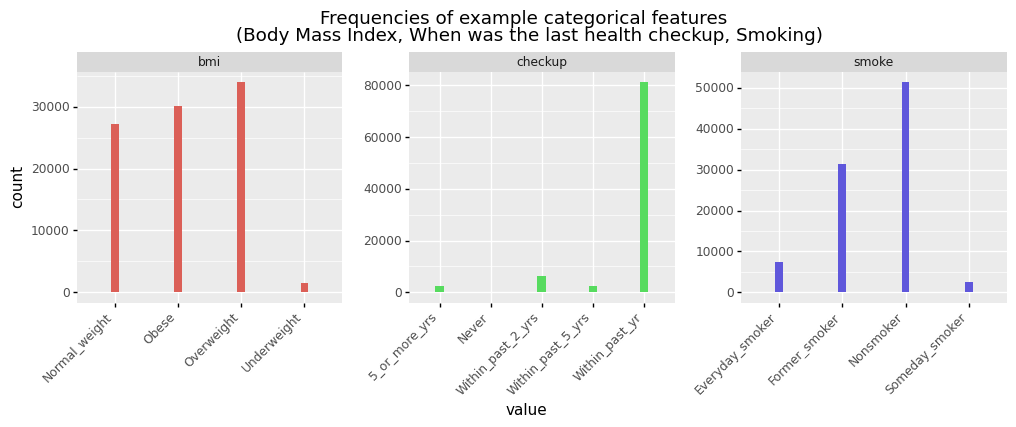

<ggplot: (328112138)>

In [190]:
temp = dat_clean[["checkup","mental_health","heavy_drinker","smoke","bmi","exercise"]]

# split data into numeric and categorical 
num = temp.select_dtypes(include = ['int64'])
cat = temp.select_dtypes(include = ['object'])

d1 = cat.melt()
# plot proportion of policy features
p8=(
    ggplot(d1,aes(x="value", fill='variable')) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    ggtitle("Frequencies of example categorical features \n (Body Mass Index, When was the last health checkup, Smoking)")+
    theme(figure_size=(12,3),
          legend_position = "none",
          subplots_adjust={'wspace':0.25, 'hspace': 0.87},
         axis_text_x=element_text(rotation=45, hjust=1))
)
p8

In [175]:
ggsave(plot=p8, filename='cat.png', dpi=300, limitsize=False)

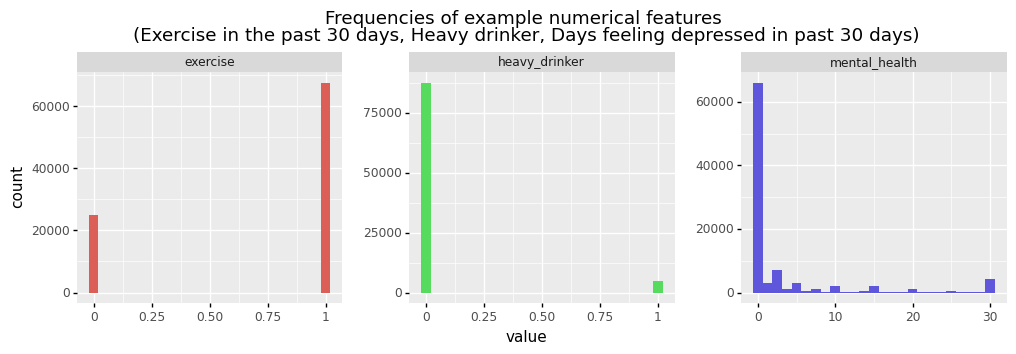

<ggplot: (328511844)>

In [191]:

# plot the distribution of numeric vars
d2 = num.melt()
p7= (
    ggplot(d2,aes(x="value", fill="variable")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    labs(title = "Frequencies of example numerical features \n(Exercise in the past 30 days, Heavy drinker, Days feeling depressed in past 30 days)")+
    theme(figure_size=(12,3),
          legend_position = "none",
          subplots_adjust={'wspace':0.25, 'hspace': 0.4})
)
p7

In [178]:
ggsave(plot=p7, filename='num.png', dpi=300, limitsize=False)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 [Text(0.5, 0, 'type2diabetes'),
  Text(1.5, 0, 'male'),
  Text(2.5, 0, 'age'),
  Text(3.5, 0, 'healthcare_coverage'),
  Text(4.5, 0, 'mental_health'),
  Text(5.5, 0, 'heart_disease'),
  Text(6.5, 0, 'kidney_disease'),
  Text(7.5, 0, 'depression'),
  Text(8.5, 0, 'concentrate_decide'),
  Text(9.5, 0, 'blind'),
  Text(10.5, 0, 'heavy_drinker'),
  Text(11.5, 0, 'exercise'),
  Text(12.5, 0, 'race'),
  Text(13.5, 0, 'employed'),
  Text(14.5, 0, 'marital'),
  Text(15.5, 0, 'edu'),
  Text(16.5, 0, 'city_rural')])

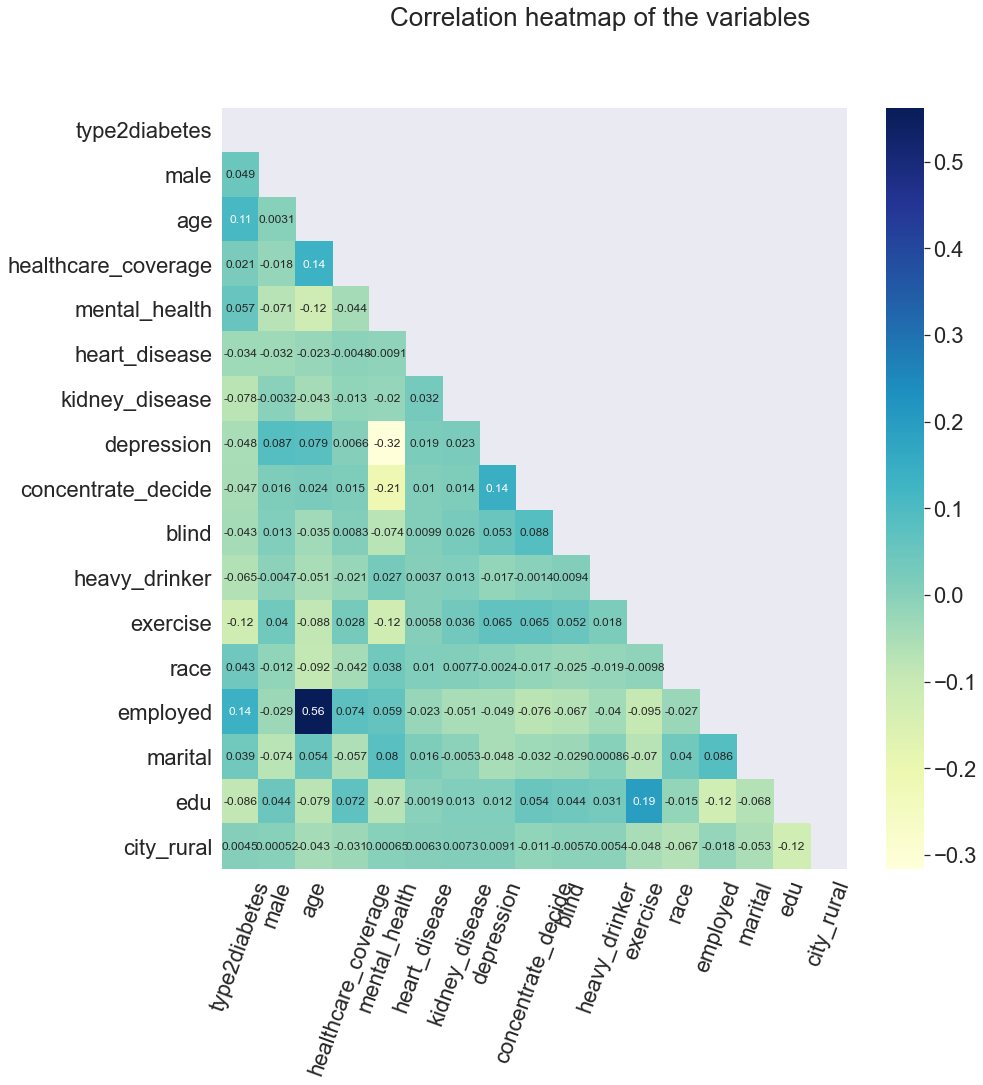

In [214]:
# create a heatmap for the cosine similarities of articles  
fig, ax = plt.subplots(figsize=(14,14))        
fig.suptitle("Correlation heatmap of the variables",fontsize=26)
corr= dat_clean.corr().astype(float)
sns.set(font_scale=2)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, annot_kws={'size': 12},
            mask=matrix,cmap="YlGnBu")

plt.savefig('corrheatmap.png', dpi=300, bbox_inches='tight')

In [209]:
pd.crosstab(index=dat_clean['income'], columns='count') 

col_0,count
income,
$10K_15K,3904
$15K_20K,5821
$20K_25K,8299
$25K_35K,10753
$35K_50K,14348
$50K_75K,16069
$75K_or_more,31130
Less_than_$10K,2427


In [195]:
dat_clean.type2diabetes.value_counts(normalize=True)

0    0.826503
1    0.173497
Name: type2diabetes, dtype: float64

In [193]:
dat_clean.income.value_counts(normalize=True)

$75K_or_more      0.335630
$50K_75K          0.173249
$35K_50K          0.154694
$25K_35K          0.115934
$20K_25K          0.089476
$15K_20K          0.062759
$10K_15K          0.042091
Less_than_$10K    0.026167
Name: income, dtype: float64

In [215]:
dat_clean

,type2diabetes,male,age,healthcare_coverage,checkup,mental_health,bmi,heart_disease,kidney_disease,depression,...,blind,heavy_drinker,smoke,exercise,income,race,employed,marital,edu,city_rural
0,0,0,11,1,Within_past_yr,0,Normal_weight,2,2,2,...,1,0,Nonsmoker,1,$25K_35K,1,7,1,3,2
1,1,0,10,1,Within_past_yr,30,Obese,2,2,2,...,2,0,Nonsmoker,1,$50K_75K,2,7,3,4,3
2,1,1,11,1,Within_past_yr,0,Obese,2,2,2,...,2,0,Everyday_smoker,1,$50K_75K,1,7,2,4,5
3,0,0,11,1,Within_past_yr,4,Normal_weight,2,2,2,...,2,0,Everyday_smoker,1,$50K_75K,1,7,2,4,1
4,0,1,12,1,Within_past_yr,0,Overweight,2,2,2,...,2,0,Former_smoker,1,$75K_or_more,1,7,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92746,1,1,11,1,Within_past_yr,0,Obese,2,2,2,...,1,0,Former_smoker,0,$15K_20K,1,7,3,3,5
92747,0,0,12,1,Within_past_yr,0,Obese,2,2,2,...,2,0,Former_smoker,1,$15K_20K,1,8,3,3,5
92748,0,0,12,1,Within_past_yr,0,Obese,2,2,2,...,2,0,Former_smoker,1,$25K_35K,1,7,2,3,1
92749,0,1,13,1,Within_past_yr,0,Overweight,2,2,2,...,2,0,Nonsmoker,1,$25K_35K,1,7,1,2,5
